## Урок 6

### Домашнее задание

1. Взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
3. Сделать feature engineering
4. Обучить любой классификатор (какой вам нравится)
5. Далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
6. Применить random negative sampling для построения классификатора в новых условиях
7. Сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
8. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [1]:
import pandas as pd  # Импортируем библиотеку pandas и сокращаем её до pd
import numpy as np   # Импортируем библиотеку numpy и сокращаем её до np
import itertools # Импорт модуля itertools для работы с итерируемыми объектами

import seaborn as sns   # Импорт библиотеки Seaborn для визуализации данных
import matplotlib.pyplot as plt # Импортируем библиотеку matplotlib.pyplot для построения графиков

# Импортируем необходимые метрики из библиотеки sklearn.metrics
from sklearn.metrics import (
    f1_score,            # F1-мера
    roc_auc_score,       # Площадь под ROC-кривой
    roc_curve,           # ROC-кривая
    precision_score,     # Точность
    classification_report,  # Отчёт о классификации
    precision_recall_curve,  # Кривая точность-полнота
    confusion_matrix       # Матрица ошибок
)

from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

# Импортируем класс LogisticRegression для логистической регрессии
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier  # Импорт класса CatBoostClassifier из библиотеки CatBoost
from sklearn.ensemble import RandomForestClassifier  # Импорт класса RandomForestClassifier из scikit-learn
from sklearn.ensemble import GradientBoostingClassifier  # Импорт класса GradientBoostingClassifier из scikit-learn

# Импортируем функцию train_test_split для разделения данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.pipeline import Pipeline, make_pipeline  # Импорт классов Pipeline и make_pipeline из scikit-learn
from sklearn.base import BaseEstimator, TransformerMixin  # Импорт базовых классов BaseEstimator и TransformerMixin
from sklearn.pipeline import FeatureUnion  # Импорт класса FeatureUnion из scikit-learn
from sklearn.preprocessing import StandardScaler  # Импорт класса StandardScaler из scikit-learn

from sklearn.model_selection import GridSearchCV 

# # Импортируем библиотеку ssl для настройки контекста SSL
# import ssl

# # Устанавливаем не проверять сертификаты SSL
# ssl._create_default_https_context = ssl._create_unverified_context

# Настраиваем формат вывода графиков в виде векторных изображений (SVG)
%config InlineBackend.figure_format = 'svg'

### 1. Взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

In [2]:
# Загружаем данные из файла 'online_shoppers_intention.csv' и сохраняем их в датафрейм df
df = pd.read_csv('./data/online_shoppers_intention.csv')

# Выводим первые строки датафрейма, чтобы ознакомиться с данными
df.head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


### Информация о датасете

<span style="color:#38705c">*__Данный набор данных включает в себя 10 числовых и 8 категориальных атрибутов.__*

*__<span style="color:#38705c">Атрибут `"Revenue"` может быть использован в качестве метки класса.</span>__*

___

<span style="color:#38705c">*`"Administrative"`, `"Administrative Duration"`, `"Informational"`, `"Informational Duration"`, `"Product Related"` и `"Product Related Duration"` представляют собой количество различных типов страниц, посещенных посетителем в сеансе и общее время, проведенное на каждой из этих категорий страниц.*

<span style="color:#38705c">*Значения этих признаков происходят из информации об URL посещенных пользователем страниц и обновляются в реальном времени при выполнении пользователем действий, например, переходе с одной страницы на другую. Признаки `"Bounce Rate"`, `"Exit Rate"` и `"Page Value"` представляют метрики, измеряемые "Google Analytics" для каждой страницы на сайте электронной коммерции.*

<span style="color:#38705c">*Значение признака `"Bounce Rate"` для веб-страницы относится к проценту посетителей, которые входят на сайт с этой страницы и затем уходят ("отскакивают") без выполнения каких-либо других запросов к серверу аналитики в течение этой сессии.*

<span style="color:#38705c">*Значение признака `"Exit Rate"` для конкретной веб-страницы рассчитывается как процент всех просмотров страницы, которые были последними в сессии.*

<span style="color:#38705c">*Признак `"Page Value"` представляет среднее значение для веб-страницы, которую посетитель посещал перед завершением транзакции в сфере электронной коммерции.*

<span style="color:#38705c">*Признак `"Special Day"` указывает на близость времени посещения сайта к конкретному особенному дню (например, День матери, День святого Валентина), в котором сессии более вероятно завершатся транзакцией.*

<span style="color:#38705c">*Значение этого признака определяется с учетом динамики электронной коммерции, такой как продолжительность между датой заказа и датой доставки. Например, для Дня святого Валентина это значение принимает ненулевое значение с 2 по 12 февраля, ноль до и после этой даты, если она не близка к другому особенному дню, и 8 февраля его максимальное значение равно 1.*</span>
___

<span style="color:#38705c">*__В набор данных также включены операционная система, браузер, регион, тип трафика, тип посетителя (повторный или новый), булево значение, указывающее, является ли дата посещения выходным днем, и месяц года.__*

In [3]:
# Выводим информацию о датафрейме df
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [4]:
# Выводим размерность датафрейма df (количество строк, количество столбцов)
df.shape


(12330, 18)

### 2. Сделать feature engineering

In [5]:
# Класс FeatureSelector предназначен для выбора указанного столбца из DataFrame
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

# Класс NumberSelector предназначен для выбора одного числового столбца из DataFrame
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

# Класс OHEEncoder предназначен для выполнения one-hot encoding на указанном столбце DataFrame
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
# Создаем копию исходного датафрейма df и сохраняем её в переменной X
X = df.copy()

# Создаем целевую переменную y, преобразуя столбец 'Revenue' в бинарные значения (0 или 1)
y = X['Revenue'].map({False: 0, True: 1})

# Удаляем столбец 'Revenue' из датафрейма X
X.drop(columns='Revenue', inplace=True)


In [7]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2)

In [8]:
# Список категориальных признаков
categorical_columns = ['SpecialDay', 'Month', 'OperatingSystems',
                        'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

# Список числовых (непрерывных) признаков
continuous_columns = ['Administrative_Duration', 'Administrative', 'Informational', 'Informational_Duration',
                       'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']


In [9]:
# Создаем пустой список final_transformers для хранения трансформаторов
final_transformers = []

# Для каждого категориального столбца создаем трансформатор, который включает в себя FeatureSelector и OHEEncoder
for cat_col in categorical_columns:
    cat_transformer = Pipeline([
        ('selector', FeatureSelector(column=cat_col)),  # Выбор указанного столбца
        ('ohe', OHEEncoder(key=cat_col))  # Применение one-hot encoding
    ])
    final_transformers.append((cat_col, cat_transformer))

# Для каждого непрерывного столбца создаем трансформатор, который включает в себя NumberSelector и StandardScaler
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
        ('selector', NumberSelector(key=cont_col)),  # Выбор указанного числового столбца
        ('standard', StandardScaler())  # Стандартизация значений
    ])
    final_transformers.append((cont_col, cont_transformer))

In [10]:
# Создаем объединение трансформаторов feats с использованием final_transformers
feats = FeatureUnion(final_transformers)

# Создаем пайплайн feature_processing, который включает в себя объединение трансформаторов feats
feature_processing = Pipeline([('feats', feats)])

### 3. Обучить любой классификатор (какой вам нравится)

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Функция выводит и рисует матрицу ошибок.
    Нормализация может быть применена, установив `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
def get_metrics(probs, model):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    # Извлечение значений из матрицы ошибок
    TN = cnf_matrix[0][0]  # True Negative
    FN = cnf_matrix[1][0]  # False Negative
    TP = cnf_matrix[1][1]  # True Positive
    FP = cnf_matrix[0][1]  # False Positive

    # Вычисление True Positive Rate (TPR) или чувствительности
    TPR = TP / (TP + FN)

    # Вычисление False Positive Rate (FPR) или вероятности ложного срабатывания
    FPR = FP / (FP + TN)

    # Вычисление True Negative Rate (TNR) или специфичности
    TNR = TN / (FP + TN)
    return model, thresholds[ix], fscore[ix], precision[ix], \
            recall[ix], roc_auc_score(y_test, probs), \
            TPR, FPR, TNR 

In [13]:
# Создаем словарь models, в котором ключами являются названия моделей, а значениями - соответствующие модели
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=2),  # Логистическая регрессия
    'CatBoostClassifier': CatBoostClassifier(n_estimators=900, 
                                             max_depth=6, 
                                             learning_rate=0.03, 
                                             l2_leaf_reg=20,
                                             silent=True, 
                                             random_state=42),  # CatBoost
    'RandomForestClassifier': RandomForestClassifier(random_state=2),  # Случайный лес
    'GradientBoostingClassifier': GradientBoostingClassifier(learning_rate=0.06, max_depth=3, min_samples_leaf=1,
                                              n_estimators=200, random_state=2)  # Градиентный бустинг
}

In [14]:
best_score = 0  # Инициализируем переменную для хранения лучшего значения метрики
best_model = None  # Инициализируем переменную для хранения лучшей модели

# Проходим по каждой модели и её имени в словаре models
for modelname, model in models.items():
    # Создаем пайплайн, который включает в себя трансформаторы feats и текущую модель
    pipeline = Pipeline([
        ('features', feats),
        (modelname, model)
    ])
    
    # Запуск кросс-валидации и оценка ROC AUC для текущей модели.
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=7, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print(f'CV score for {modelname} is {cv_score}+-{cv_score_std}')

    # Сравнение текущего показателя с лучшим показателем и обновление лучшего показателя и модели при необходимости
    if cv_score > best_score:
        best_score = cv_score
        best_model = model
        
# Создание пайплайна с лучшей моделью.
classifier = Pipeline([
    ('features', feats),
    ('classifier', best_model)
])

# Обучение пайплайна на всем тренировочном датасете с использованием лучшей модели.
classifier.fit(X_train, y_train)

# Прогнозирование вероятностей и вывод информации о наилучшей производительности модели.
preds = classifier.predict_proba(X_test)[:, 1]
print(f'\nНаилучшую производительность показал алгоритм {type(best_model).__name__}')

CV score for LogisticRegression is 0.8900262514352645+-0.008926549936243379
CV score for CatBoostClassifier is 0.933645763957383+-0.009837396567383574
CV score for RandomForestClassifier is 0.9228404404852288+-0.011048495546578163
CV score for GradientBoostingClassifier is 0.9315050668780669+-0.008643994576925464

Наилучшую производительность показал алгоритм CatBoostClassifier


In [15]:
# Создаем словарь models_metrics для хранения метрик производительности моделей
models_metrics = {
    'model': [],  # Имя модели
    'best_threshold': [],  # Лучший порог для бинаризации предсказаний
    'f-score': [],  # F-мера
    'precision': [],  # Точность
    'recall': [],  # Полнота (recall)
    'roc-auc': [],  # Площадь под ROC-кривой
    'true_positive_rate': [],  # True Positive Rate (чувствительность)
    'false_positive_rate': [],  # False Positive Rate (специфичность)
    'true_negative_rate': []  # True Negative Rate
}

In [16]:
# Проходим по каждой модели и её имени в словаре models
for modelname, model in models.items():
    # Создаем пайплайн, который включает в себя трансформаторы feats и текущую модель
    classifier_pipeline = Pipeline([
        ('features', feats),
        ('classifier', model)
    ])
    
    # Обучаем пайплайн на всем тренировочном датасете с использованием лучшей модели
    classifier_pipeline.fit(X_train, y_train)
    
    # Прогнозируем вероятности на тестовом датасете
    preds = classifier_pipeline.predict_proba(X_test)[:, 1]
    
    # Вычисляем метрики производительности модели с использованием функции get_metrics
    for key_value, metric in zip(models_metrics.keys(), get_metrics(preds, modelname)):
        if isinstance(metric, (int, float)):
            # Если метрика числовая, округляем её до 4 знаков после запятой и добавляем в словарь
            metric = f'{metric:.4f}'
            if metric not in models_metrics.get(key_value):
                models_metrics[key_value].append(float(metric))
            else:
                pass
        else:
            # Если метрика не числовая, добавляем в словарь
            if metric not in models_metrics.get(key_value):
                models_metrics[key_value].append(metric)
            else:
                pass

In [17]:
# Создаем DataFrame df_models_metrics из словаря models_metrics
df_models_metrics = pd.DataFrame(models_metrics)

# Выводим DataFrame с метриками производительности моделей
df_models_metrics

,model,best_threshold,f-score,precision,recall,roc-auc,true_positive_rate,false_positive_rate,true_negative_rate
0,LogisticRegression,0.2383,0.6012,0.5812,0.6226,0.8862,0.6205,0.0821,0.9179
1,CatBoostClassifier,0.3651,0.6680,0.6612,0.6751,0.9312,0.6730,0.0633,0.9367
2,RandomForestClassifier,0.3200,0.6622,0.6121,0.7212,0.9203,0.7107,0.0814,0.9186
3,GradientBoostingClassifier,0.2695,0.6864,0.6142,0.7778,0.9334,0.7757,0.0894,0.9106


Confusion matrix, without normalization
[[2374  232]
 [ 107  370]]


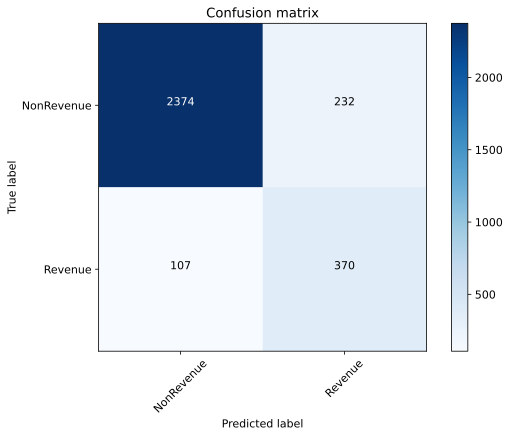

In [18]:
# Устанавливаем размер шрифта для графика
font = {'size' : 11}
plt.rc('font', **font)

# Вычисляем матрицу ошибок
cnf_matrix = confusion_matrix(y_test, preds > df_models_metrics.loc[df_models_metrics['roc-auc'].idxmax(),\
                                                                    'best_threshold'])
# Создаем график
plt.figure(figsize=(8, 6))
# Выводим матрицу ошибок с помощью функции plot_confusion_matrix
plot_confusion_matrix(cnf_matrix, classes=['NonRevenue', 'Revenue'],
                      title='Confusion matrix')
# Сохраняем график в файл
plt.savefig("./image/conf_matrix_1.png")

# Отображаем график
plt.show()

In [19]:
# param_grid = {
#     'classifier__n_estimators': [100, 200, 300],  # Пример значений для n_estimators
#     'classifier__learning_rate': [0.04, 0.05, 0.06],  # Пример значений для learning_rate
#     'classifier__max_depth': [3, 4, 5],  # Пример значений для max_depth
#     'classifier__min_samples_leaf': [1, 2, 3]  # Пример значений для min_samples_leaf
# }


In [20]:
# # Создаем объект GridSearchCV для поиска по сетке
# grid_search = GridSearchCV(classifier_pipeline, param_grid=param_grid, cv=6, scoring='accuracy', refit=False)

In [21]:
# %%time 

# # Запускаем процесс поиска по сетке с использованием данных обучения
# grid_search.fit(X_train, y_train)

# # Выводим лучшие параметры, найденные в результате поиска по сетке
# print("Best Parameters: ", grid_search.best_params_)

# # Выводим лучшую точность (accuracy) модели, найденную в результате поиска по сетке
# print("Best Accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

In [22]:
# Создаем пайплайн classifier с предобработкой признаков и моделью GradientBoostingClassifier
classifier = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(learning_rate=0.06, max_depth=3, min_samples_leaf=1,
                                              n_estimators=200, random_state=2))
])

# Обучаем пайплайн classifier на обучающих данных
classifier.fit(X_train, y_train)

# Прогнозируем вероятности классов для тестовых данных
y_predict = classifier.predict_proba(X_test)[:, 1]

# Вычисляем пороги для классификации с помощью функции get_metrics
thresholds = get_metrics(y_predict, 'classifier')[1]


Confusion matrix, without normalization
[[2373  233]
 [ 107  370]]


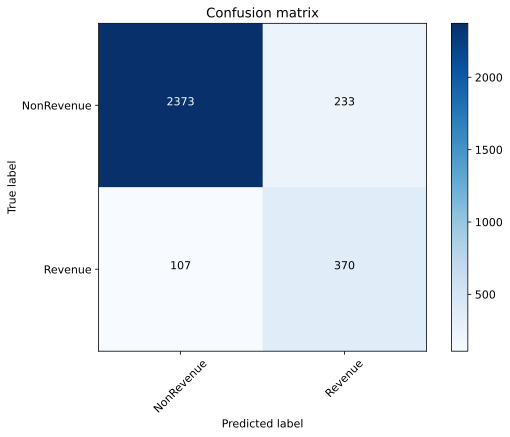

In [23]:
# Устанавливаем размер шрифта для графика
font = {'size' : 11}
plt.rc('font', **font)

# Вычисляем матрицу ошибок
cnf_matrix = confusion_matrix(y_test, y_predict>thresholds)

# Создаем график
plt.figure(figsize=(8, 6))
# Выводим матрицу ошибок с помощью функции plot_confusion_matrix
plot_confusion_matrix(cnf_matrix, classes=['NonRevenue', 'Revenue'], title='Confusion matrix')

# Сохраняем график в файл
plt.savefig("./image/conf_matrix_2.png")

# Отображаем график
plt.show()

### 4. Далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть

In [24]:
# Создаем новый столбец 'revenue' с бинарными значениями
revenue = df['Revenue'].map({False: 0, True: 1})

# Создаем новый датафрейм data, который объединяет все столбцы, кроме 'Revenue', с новым столбцом 'revenue'
data = pd.concat([df.iloc[:, :-1], revenue], axis=1)

# Создаем копию датафрейма data
modification_data = data.copy()

# Определяем желаемое отношение положительных примеров к общему количеству примеров
pos_labels_ratio = 0.1

# Находим индексы положительных примеров и перемешиваем их
pos_ind = np.where(data.loc[:, 'Revenue'].values == 1)[0]
np.random.shuffle(pos_ind)

# Вычисляем количество положительных примеров, которые будут использоваться
pos_sample_len = int(np.ceil(pos_labels_ratio * len(pos_ind)))

# Выводим информацию о количестве положительных примеров, которые будут использоваться
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]


Using 191/1908 as positives and unlabeling the rest


### 5. Применить random negative sampling для построения классификатора в новых условиях

In [25]:
# Создаем новый столбец 'class_test' и инициализируем его значениями -1
modification_data['class_test'] = -1

# Устанавливаем значения 1 в столбце 'class_test' для выбранных положительных примеров
modification_data.loc[pos_sample, 'class_test'] = 1

# Выводим информацию о распределении значений в столбце 'class_test'
print('target variable:\n', modification_data.iloc[:,-1].value_counts())


target variable:
 -1    12139
 1      191
Name: class_test, dtype: int64


In [26]:
# Создаем переменную x_data, которая содержит признаки для обучения модели
# исключая два последних столбца с помощью iloc и :-2.
x_data = modification_data.iloc[:, :-2].values

# Создаем переменную y_labeled, которая содержит метки классов для обучения модели,
# выбирая последний столбец (предпоследний столбец в modification_data).
y_labeled = modification_data.iloc[:, -1].values

# Создаем переменную y_positive, которая содержит метки классов для положительных примеров,
# выбирая предпоследний столбец (последний столбец в modification_data).
y_positive = modification_data.iloc[:, -2].values


In [27]:
# Перемешиваем данные в случайном порядке.
modification_data = modification_data.sample(frac=1)

# Выбираем отрицательные примеры из modification_data, где 'class_test' равен -1,
# в количестве, равном количеству положительных примеров, и сохраняем их в переменной neg_sample.
neg_sample = modification_data[modification_data['class_test'] == -1]\
[:len(modification_data[modification_data['class_test'] == 1])]

# Выбираем оставшиеся отрицательные примеры, которые не были включены в neg_sample, 
# и сохраняем их в переменной sample_test.
sample_test = modification_data[modification_data['class_test'] == -1]\
[len(modification_data[modification_data['class_test'] == 1]):]

# Выбираем положительные примеры из modification_data, где 'class_test' равен 1, 
# и сохраняем их в переменной pos_sample.
pos_sample = modification_data[modification_data['class_test'] == 1]

# Выводим размеры neg_sample и pos_sample.
print(neg_sample.shape, pos_sample.shape)

# Объединяем отрицательные и положительные примеры в обучающий набор данных sample_train
# и перемешиваем данные в нем.
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)


(191, 19) (191, 19)


In [28]:
def evaluate_results(test, y_predict):
    # Выводим заголовок для результатов классификации
    print('Classification results:')
    
    # Вычисляем F1-меру и выводим результат
    f1 = f1_score(test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    
    # Вычисляем ROC-AUC и выводим результат
    roc = roc_auc_score(test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    
    # Вычисляем полноту и выводим результат
    rec = recall_score(test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    
    # Вычисляем точность и выводим результат
    prc = precision_score(test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0))


In [29]:
# Создаем модель пайплайна, включающего преобразование признаков (feats) 
# и классификатор (GradientBoostingClassifier).
model = Pipeline([
    ('features', feats),  # Преобразование признаков
    ('classifier', GradientBoostingClassifier(learning_rate=0.06, max_depth=3, min_samples_leaf=1, 
                                              n_estimators=200, random_state=2))  # Классификатор
])

# Обучаем модель на обучающем наборе данных sample_train, исключая два последних столбца.
model.fit(sample_train.iloc[:, :-2], sample_train.iloc[:, -2])

# Прогнозируем значения для тестового набора данных, исключая два последних столбца.
y_predict = model.predict(sample_test.iloc[:, :-2])

# Оцениваем результаты, сравнивая прогнозированные значения (y_predict) с фактическими 
# значениями (sample_test.iloc[:,-2].values).
evaluate_results(sample_test.iloc[:,-2].values, y_predict)


Classification results:
f1: 56.02%
roc: 83.66%
recall: 88.08%
precision: 41.07%


### 6. Сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)

In [30]:
# Создаем словарь models_metrics для хранения метрик производительности моделей
models_metrics = {
    'model': [],  # Имя модели
    'best_threshold': [],  # Лучший порог для бинаризации предсказаний
    'f-score': [],  # F-мера
    'precision': [],  # Точность
    'recall': [],  # Полнота (recall)
    'roc-auc': [],  # Площадь под ROC-кривой
    'true_positive_rate': [],  # True Positive Rate (чувствительность)
    'false_positive_rate': [],  # False Positive Rate (специфичность)
    'true_negative_rate': []  # True Negative Rate
}

In [31]:
# Создаем пайплайн, который включает в себя трансформаторы feats и текущую модель
classifier_pipeline = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(learning_rate=0.06, max_depth=3, min_samples_leaf=1,
                                              n_estimators=200, random_state=2))])

# Обучаем пайплайн на всем тренировочном датасете с использованием лучшей модели
classifier_pipeline.fit(X_train, y_train)

# Прогнозируем вероятности на тестовом датасете
preds = classifier_pipeline.predict_proba(X_test)[:, 1]

# Вычисляем метрики производительности модели с использованием функции get_metrics
for key_value, metric in zip(models_metrics.keys(), get_metrics(preds, 'GradientBoostingClassifier')):
    if isinstance(metric, (int, float)):
        # Если метрика числовая, округляем её до 4 знаков после запятой и добавляем в словарь
        metric = float(f'{metric:.4f}')
        if metric not in models_metrics.get(key_value):
            models_metrics[key_value].append(float(metric))
        else:
            pass
    else:
        # Если метрика не числовая, добавляем в словарь
        if metric not in models_metrics.get(key_value):
            models_metrics[key_value].append(metric)
        else:
            pass
        
thresholds = get_metrics(preds, 'classifier')[1]

Confusion matrix, without normalization
[[2373  233]
 [ 107  370]]


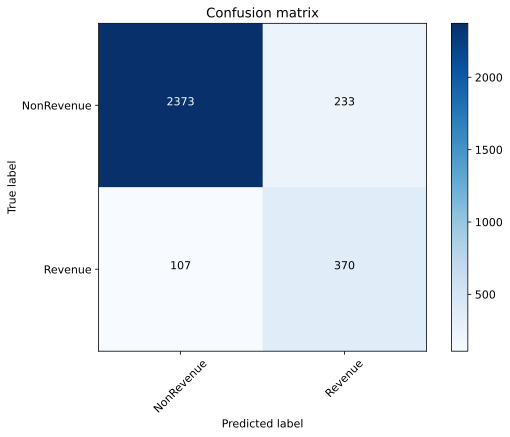

In [32]:
# Устанавливаем размер шрифта для графика
font = {'size' : 11}
plt.rc('font', **font)

# Вычисляем матрицу ошибок
cnf_matrix = confusion_matrix(y_test, preds>thresholds)

# Создаем график
plt.figure(figsize=(8, 6))
# Выводим матрицу ошибок с помощью функции plot_confusion_matrix
plot_confusion_matrix(cnf_matrix, classes=['NonRevenue', 'Revenue'], title='Confusion matrix')

# Сохраняем график в файл
plt.savefig("./image/conf_matrix_3.png")

# Отображаем график
plt.show()

In [33]:
def get_metrics_negative_sampling(probs, model):
    precision, recall, thresholds = precision_recall_curve(sample_test.iloc[:,-2], probs)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    cnf_matrix = confusion_matrix(sample_test.iloc[:,-2], y_predict)
    # cnf_matrix = confusion_matrix(sample_test.iloc[:,-2], y_predict>thresholds[ix])
    # Извлечение значений из матрицы ошибок
    TN = cnf_matrix[0][0]  # True Negative
    FN = cnf_matrix[1][0]  # False Negative
    TP = cnf_matrix[1][1]  # True Positive
    FP = cnf_matrix[0][1]  # False Positive

    # Вычисление True Positive Rate (TPR) или чувствительности
    TPR = TP / (TP + FN)

    # Вычисление False Positive Rate (FPR) или вероятности ложного срабатывания
    FPR = FP / (FP + TN)

    # Вычисление True Negative Rate (TNR) или специфичности
    TNR = TN / (FP + TN)
    return model, thresholds[ix], fscore[ix], precision[ix], \
            recall[ix], roc_auc_score(sample_test.iloc[:,-2], probs), \
            TPR, FPR, TNR 

In [34]:
# Создаем пайплайн, который включает в себя трансформаторы feats и текущую модель
negative_sampling = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(learning_rate=0.06, max_depth=3, min_samples_leaf=1,
                                              n_estimators=200, random_state=2))])

# Обучаем пайплайн на всем тренировочном датасете с использованием лучшей модели
negative_sampling.fit(sample_train.iloc[:,:-2],
                      sample_train.iloc[:,-2])

# Прогнозируем вероятности на тестовом датасете
y_predict = negative_sampling.predict(sample_test.iloc[:,:-2])

# Вычисляем метрики производительности модели с использованием функции get_metrics
for key_value, metric in zip(models_metrics.keys(), get_metrics_negative_sampling(y_predict, 'RNegSampling')):
    if isinstance(metric, (int, float)):
        # Если метрика числовая, округляем её до 4 знаков после запятой и добавляем в словарь
        metric = float(f'{metric:.4f}')
        if metric not in models_metrics.get(key_value):
            models_metrics[key_value].append(float(metric))
        else:
            pass
    else:
        # Если метрика не числовая, добавляем в словарь
        if metric not in models_metrics.get(key_value):
            models_metrics[key_value].append(metric)
        else:
            pass

In [35]:
pd.DataFrame(models_metrics)

,model,best_threshold,f-score,precision,recall,roc-auc,true_positive_rate,false_positive_rate,true_negative_rate
0,GradientBoostingClassifier,0.2695,0.6864,0.6142,0.7778,0.9334,0.7757,0.0894,0.9106
1,RNegSampling,1.0000,0.5602,0.4107,0.8808,0.8366,0.8808,0.2077,0.7923


Confusion matrix, without normalization
[[8131 2131]
 [ 201 1485]]


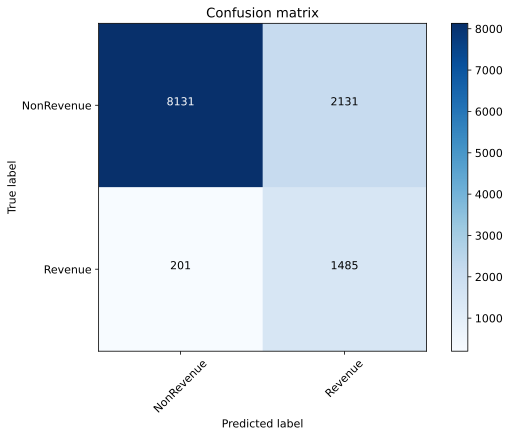

In [36]:
# Устанавливаем размер шрифта для графика
font = {'size' : 11}
plt.rc('font', **font)

# Вычисляем матрицу ошибок
cnf_matrix = confusion_matrix(sample_test.iloc[:,-2], y_predict)

# Создаем график
plt.figure(figsize=(8, 6))
# Выводим матрицу ошибок с помощью функции plot_confusion_matrix
plot_confusion_matrix(cnf_matrix, classes=['NonRevenue', 'Revenue'], title='Confusion matrix')

# Сохраняем график в файл
plt.savefig("./image/conf_matrix_4.png")

# Отображаем график
plt.show()

### 7. Поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [37]:
# Преобразование данных:
# Создаем столбец "revenue", где True заменяется на 1, а False на 0.
revenue = df['Revenue'].map({False: 0, True: 1})

# Объединяем столбец "revenue" с исходными данными, создавая новый датафрейм "data".
data = pd.concat([df.iloc[:, :-1], revenue], axis=1)

# Создаем копию исходных данных для дальнейших модификаций.
modification_data = data.copy()

# Определение баланса классов:
# Задаем желаемое отношение положительных меток к общему количеству меток (5% положительных меток в данном случае).
pos_labels_ratio = 0.05

# Получаем индексы положительных меток (revenue = 1) и перемешиваем их.
pos_ind = np.where(data.loc[:, 'Revenue'].values == 1)[0]
np.random.shuffle(pos_ind)

# Выбираем случайный набор положительных меток, соответствующий желаемому отношению.
pos_sample_len = int(np.ceil(pos_labels_ratio * len(pos_ind)))

print(f'Используем {pos_sample_len}/{len(pos_ind)} положительных меток и снимаем остальные метки.')

pos_sample = pos_ind[:pos_sample_len]


Используем 96/1908 положительных меток и снимаем остальные метки.


In [38]:
# Добавление столбца "class_test" с метками:
# Создаем новый столбец "class_test" в датафрейме "modification_data" и инициализируем его значениями -1.
modification_data['class_test'] = -1

# Устанавливаем значения 1 в столбце "class_test" для выбранных случайно положительных меток.
modification_data.loc[pos_sample, 'class_test'] = 1

# Подготовка данных для обучения:
# Создаем массив "x_data", содержащий признаки (все столбцы до предпоследнего столбца в "modification_data").
x_data = modification_data.iloc[:, :-2].values 

# Создаем массив "y_labeled", содержащий метки классов (столбец "class_test" в "modification_data").
y_labeled = modification_data.iloc[:, -1].values

# Создаем массив "y_positive", содержащий положительные метки (столбец "Revenue" в "modification_data").
y_positive = modification_data.iloc[:, -2].values


In [39]:
# Перемешивание данных:
# Перемешиваем данные в "modification_data", чтобы случайно распределить их порядок.
modification_data = modification_data.sample(frac=1)

# Выбор негативных меток:
# Создаем датафрейм "neg_sample", который содержит только негативные метки (значение "class_test" равно -1).
neg_sample = modification_data[modification_data['class_test'] == -1]\
[:len(modification_data[modification_data['class_test'] == 1])]

# Создаем датафрейм "sample_test", который содержит оставшиеся негативные метки после выбора для обучения.
sample_test = modification_data[modification_data['class_test'] == -1]\
[len(modification_data[modification_data['class_test'] == 1]):]

# Создаем датафрейм "pos_sample", который содержит положительные метки.
pos_sample = modification_data[modification_data['class_test'] == 1]

# Выводим информацию о размере "neg_sample" и "pos_sample".
print(neg_sample.shape, pos_sample.shape)

# Объединение данных для обучения:
# Создаем "sample_train", который объединяет "neg_sample" и "pos_sample" и затем перемешивается, 
# чтобы получить окончательный обучающий набор данных.
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)


(96, 19) (96, 19)


In [40]:
# Определение модели:
# Создается пайплайн, включающий предварительную обработку признаков и модель GradientBoostingClassifier с 
# определенными параметрами.
model = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(learning_rate=0.06, max_depth=3, min_samples_leaf=1,
                                              n_estimators=200, random_state=2))
])

# Обучение модели:
# Обучаем модель на данных из обучающего набора "sample_train".
model.fit(sample_train.iloc[:, :-2], sample_train.iloc[:, -2])

# Получение предсказаний:
# Получаем предсказания модели на данных из тестового набора "sample_test".
y_predict = model.predict(sample_test.iloc[:, :-2])

# Оценка результатов:
# Оцениваем результаты, сравнивая фактические значения (sample_test.iloc[:,-2].values) с предсказанными 
# значениями (y_predict).
evaluate_results(sample_test.iloc[:, -2].values, y_predict)


Classification results:
f1: 54.84%
roc: 81.55%
recall: 84.63%
precision: 40.57%
